# So overall, this is the same as the binary classifier from the first binary classifier, except we also have shorting as well

In this case, we would be executing  trades risking 2% in total of our capital when to buy and when to short. That way we will also make sure not to loose our total capital in general, and we will also simulate liquidation. Meaning, any other stuff that was updated in the first binary classifier we go over and put it in this classifier as well

**Rules:**
-Preprocess the data
-Define model architecture
-Train the model and feed the data to it
-F1-Score & Backtesting

**Live simulation---**
Best to do 50 iterations for all tests in general, look at your python script on your desktop to execute, load, and run them all, after cleaning what needs to be done. Mind you any metatrader5 data we are fetching is being simulated here, nothign is being reflected within our account. 

In [1]:
#making sure we train with our GPU, Pytorch is the fucking shit!!!
import torch
torch.cuda.is_available()

True

In [2]:
torch.cuda.device_count()

1

In [3]:
torch.cuda.current_device()

0

In [4]:
torch.cuda.device(0)

In [5]:
torch.cuda.get_device_name(0)

'NVIDIA TITAN RTX'

In [6]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import os
import warnings

# Set multiprocessing method
torch.multiprocessing.set_start_method('spawn', force=True)

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Custom Dataset class with exception handling
class BitcoinDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        try:
            features = self.features[idx]
            label = self.labels[idx]
            return features, label
        except Exception as e:
            print(f"Error loading data at index {idx}: {e}")
            return torch.tensor([]), torch.tensor([])  # Return empty tensors on error

# Load the preprocessed data
data_paths = {
    'minute11': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/profit005/minute1_trained.csv',
    'minute1_22': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/profit005/bitcoinm1_2.csv',
    'minute1_33': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/profit005/bitcoinm1_3.csv',
    'minute1_44': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/profit005/bitcoinm1_4.csv',
    'minute1_555': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/profit005/bitcoinm1_5.csv',
    'minute1_66': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/profit005/bitcoinm1_6.csv',
    'minute1_77': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/profit005/bitcoinm1_7.csv',
    'minute55': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/profit005/minute5_trained.csv',
    'minute155': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/profit005/minute15_trained.csv',
    'minute300': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/profit005/minute30_trained.csv',
    'minute301': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/profit005/bitcoinm1_8.csv',
    'minute302': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/profit005/bitcoinm1_9.csv',
    'minute303': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/profit005/bitcoinm1_10.csv',
    'minute304': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/profit005/bitcoinm1_11.csv',
    'minute305': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/profit005/bitcoinm1_12.csv',
    'minute306': 'C:/Users/gunne/OneDrive/Desktop/bitcoin/profit005/bitcoinm1_13.csv'
}

# Function to load and concatenate datasets
def load_data(data_paths):
    data_frames = []
    for key, path in data_paths.items():
        df = pd.read_csv(path, dtype={'DateTime': str})  # Specify dtype for 'DateTime' column
        df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')  # Convert 'DateTime' to datetime
        df = df.set_index('DateTime')
        data_frames.append(df)
    combined_data = pd.concat(data_frames, axis=0)
    return combined_data

# Load and combine datasets
combined_data = load_data(data_paths)

# Debug: print the shape of the combined data
print(f"Combined data shape: {combined_data.shape}")

# Debug: check for NaNs in the data
nan_info = combined_data.isna().sum()
print("NaN values in each column:\n", nan_info)

# Drop columns that are completely NaN or have excessive NaNs
combined_data.drop(columns=['Unnamed: 13', 'Unnamed: 14'], inplace=True)

# Fill NaNs in 'Profit_Between_Time_Series' with a default value (e.g., 0)
combined_data['Profit_Between_Time_Series'].fillna(0, inplace=True)

# Ensure there are no NaNs in the features and labels before splitting
assert not combined_data.isna().any().any(), "Data contains NaNs before splitting"

# Separate features and labels
features = combined_data.drop(columns=['Buy_Signal', 'Sell_Signal']).values
buy_labels = combined_data['Buy_Signal'].values
sell_labels = combined_data['Sell_Signal'].values

# Check for NaNs in features and labels before splitting
assert not np.isnan(features).any(), "Features contain NaNs before splitting"
assert not np.isnan(buy_labels).any(), "Buy labels contain NaNs before splitting"
assert not np.isnan(sell_labels).any(), "Sell labels contain NaNs before splitting"

# Debug: print the shapes of features and labels
print(f"Features shape: {features.shape}, Buy labels shape: {buy_labels.shape}, Sell labels shape: {sell_labels.shape}")

# Split the data
train_features, test_features, train_buy_labels, test_buy_labels, train_sell_labels, test_sell_labels = train_test_split(
    features, buy_labels, sell_labels, test_size=0.2, shuffle=False)
train_features, val_features, train_buy_labels, val_buy_labels, train_sell_labels, val_sell_labels = train_test_split(
    train_features, train_buy_labels, train_sell_labels, test_size=0.2, shuffle=False)

# Standardize the data
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# Check for NaNs in standardized features
assert not np.isnan(train_features).any(), "Train features contain NaNs after standardization"
assert not np.isnan(val_features).any(), "Validation features contain NaNs after standardization"
assert not np.isnan(test_features).any(), "Test features contain NaNs after standardization"

# Check data for NaNs and infinities
def check_data_for_nans(features, labels):
    if np.isnan(features).any() or np.isnan(labels).any():
        raise ValueError("Data contains NaNs")
    if np.isinf(features).any() or np.isinf(labels).any():
        raise ValueError("Data contains infinite values")

# Check training and validation data
check_data_for_nans(train_features, train_buy_labels)
check_data_for_nans(val_features, val_buy_labels)

# Create DataLoader function with conditional persistent_workers
def create_dataloader(features, labels, batch_size=2048, shuffle=True, num_workers=0):
    dataset = BitcoinDataset(features, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True,
                            persistent_workers=num_workers > 0)
    return dataloader

# Define batch_size
batch_size = 2048  # Adjust to fit GPU memory

# Create DataLoaders for buy signals
train_buy_loader = create_dataloader(train_features, train_buy_labels, batch_size, num_workers=0)
val_buy_loader = create_dataloader(val_features, val_buy_labels, batch_size, num_workers=0)
test_buy_loader = create_dataloader(test_features, test_buy_labels, batch_size, num_workers=0)

# Create DataLoaders for sell signals
train_sell_loader = create_dataloader(train_features, train_sell_labels, batch_size, num_workers=0)
val_sell_loader = create_dataloader(val_features, val_sell_labels, batch_size, num_workers=0)
test_sell_loader = create_dataloader(test_features, test_sell_labels, batch_size, num_workers=0)

print("Data Loaders created successfully!")

# Set the device for training (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Combined data shape: (3626370, 14)
NaN values in each column:
 OPEN                                0
HIGH                                0
LOW                                 0
CLOSE                               0
TICKVOL                             0
VOL                                 0
SPREAD                              0
Change_Open_Close                   0
Change_High_Low                     0
Profit_Between_Time_Series          1
Buy_Signal                          0
Sell_Signal                         0
Unnamed: 13                   3626370
Unnamed: 14                   3626369
dtype: int64
Features shape: (3626370, 10), Buy labels shape: (3626370,), Sell labels shape: (3626370,)
Data Loaders created successfully!
Using device: cuda


In [7]:
import torch.nn as nn
import torch.optim as optim
import torch

# Define the RNN model with batch normalization and 15 activation layers
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fc7 = nn.Linear(hidden_size, hidden_size)
        self.fc8 = nn.Linear(hidden_size, hidden_size)
        self.fc9 = nn.Linear(hidden_size, hidden_size)
        self.fc10 = nn.Linear(hidden_size, hidden_size)
        self.fc11 = nn.Linear(hidden_size, hidden_size)
        self.fc12 = nn.Linear(hidden_size, hidden_size)
        self.fc13 = nn.Linear(hidden_size, hidden_size)
        self.fc14 = nn.Linear(hidden_size, hidden_size)
        self.fc15 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.relu(self.fc4(out))
        out = torch.relu(self.fc5(out))
        out = torch.relu(self.fc6(out))
        out = torch.relu(self.fc7(out))
        out = torch.relu(self.fc8(out))
        out = torch.relu(self.fc9(out))
        out = torch.relu(self.fc10(out))
        out = torch.relu(self.fc11(out))
        out = torch.relu(self.fc12(out))
        out = torch.relu(self.fc13(out))
        out = torch.relu(self.fc14(out))
        out = self.fc15(out)
        return out

# Model parameters
input_size = combined_data.shape[1] - 2  # Number of features (exclude 'Buy_Signal' and 'Sell_Signal')
hidden_size = 1024  # Adjust hidden size
num_layers = 8  # Number of LSTM layers
output_size = 2  # Binary classification (buy and sell signals)

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Initialize the model, loss function, and optimizer
model = BitcoinPriceLSTM(input_size, hidden_size, num_layers, output_size, dropout=0.5).to(device)

# Initialize weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)

model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Reduced learning rate and increased L2 regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

print("Model, loss function, and optimizer created successfully!")




CUDA is available. Using GPU.
Device name: NVIDIA TITAN RTX
Model, loss function, and optimizer created successfully!


In [8]:
# Function to count the number of parameters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters in the model
num_params = count_parameters(model)
print(f'The model has {num_params:,} trainable parameters')

The model has 77,717,506 trainable parameters


In [9]:
#Make sure we are training fully on our GPU

In [ ]:
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# Ensure the model is moved to the GPU
model = model.to(device)

# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10):
    scaler = GradScaler()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(inputs.unsqueeze(1))  # Add batch dimension for LSTM
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        val_loss = validate_model(model, val_loader, criterion)
        
        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s")
    
    return train_losses, val_losses

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            with autocast():
                outputs = model(inputs.unsqueeze(1))  # Add batch dimension for LSTM
                loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
    
    val_loss = running_loss / len(val_loader.dataset)
    return val_loss

# Plot loss function
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss over Epochs')
    plt.show()

# Number of epochs for training
num_epochs = 55

# Train the model and get the losses
train_losses, val_losses = train_model(model, train_buy_loader, val_buy_loader, criterion, optimizer, scheduler, num_epochs, patience=10)

# Plot the losses
plot_losses(train_losses, val_losses)


Epoch 1/55: 100%|███████████████████████████████████████████████████████████████| 1134/1134 [01:12<00:00, 15.62batch/s]


Epoch 1/55, Loss: 0.1408, Val Loss: 0.0556, Time: 83.67s


Epoch 2/55: 100%|███████████████████████████████████████████████████████████████| 1134/1134 [01:13<00:00, 15.53batch/s]


Epoch 2/55, Loss: 0.0851, Val Loss: 0.0389, Time: 84.19s


Epoch 3/55: 100%|███████████████████████████████████████████████████████████████| 1134/1134 [01:12<00:00, 15.69batch/s]


Epoch 3/55, Loss: 0.0827, Val Loss: 0.0386, Time: 82.28s


Epoch 4/55: 100%|███████████████████████████████████████████████████████████████| 1134/1134 [01:12<00:00, 15.56batch/s]


Epoch 4/55, Loss: 0.0812, Val Loss: 0.0469, Time: 83.74s


Epoch 5/55: 100%|███████████████████████████████████████████████████████████████| 1134/1134 [01:12<00:00, 15.58batch/s]


Epoch 5/55, Loss: 0.0787, Val Loss: 0.0275, Time: 83.51s


Epoch 6/55: 100%|███████████████████████████████████████████████████████████████| 1134/1134 [01:13<00:00, 15.47batch/s]


Epoch 6/55, Loss: 0.0544, Val Loss: 0.0090, Time: 83.31s


Epoch 7/55: 100%|███████████████████████████████████████████████████████████████| 1134/1134 [01:12<00:00, 15.56batch/s]


Epoch 7/55, Loss: 0.0400, Val Loss: 0.0069, Time: 83.43s


Epoch 8/55: 100%|███████████████████████████████████████████████████████████████| 1134/1134 [01:13<00:00, 15.46batch/s]


Epoch 8/55, Loss: 0.0358, Val Loss: 0.0061, Time: 83.75s


Epoch 9/55: 100%|███████████████████████████████████████████████████████████████| 1134/1134 [01:13<00:00, 15.49batch/s]


Epoch 9/55, Loss: 0.0329, Val Loss: 0.0045, Time: 84.09s


Epoch 10/55: 100%|██████████████████████████████████████████████████████████████| 1134/1134 [01:12<00:00, 15.54batch/s]


Epoch 10/55, Loss: 0.0312, Val Loss: 0.0050, Time: 83.31s


Epoch 11/55:  98%|████████████████████████████████████████████████████████████▌ | 1107/1134 [01:11<00:01, 15.54batch/s]

Test Loss: 0.0051
Accuracy: 0.9989
Precision: 0.9997
Recall: 0.9945
F1 Score: 0.9971


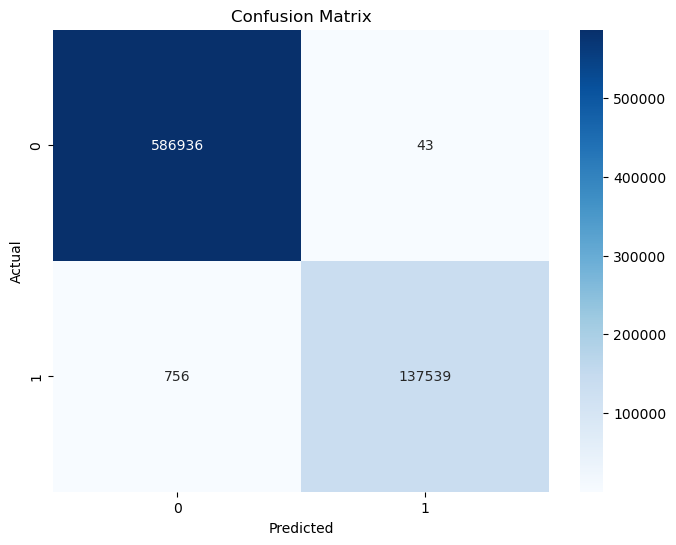

In [12]:
#F1 Score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs.unsqueeze(1))  # Add batch dimension for LSTM
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    test_loss = running_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')
    
    return all_labels, all_preds

# Evaluate on test_buy_loader or test_sell_loader depending on your focus
all_labels, all_preds = evaluate_model(model, test_buy_loader, criterion)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [16]:
#Save the model:
import torch

# Save the entire model
torch.save(model, '005_1model.pth')

In [17]:
# Save the model
torch.save(model.state_dict(), '005_1model.pth')
print("Model saved successfully!")

Model saved successfully!


In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Define the RNN model with batch normalization and 15 activation layers
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fc7 = nn.Linear(hidden_size, hidden_size)
        self.fc8 = nn.Linear(hidden_size, hidden_size)
        self.fc9 = nn.Linear(hidden_size, hidden_size)
        self.fc10 = nn.Linear(hidden_size, hidden_size)
        self.fc11 = nn.Linear(hidden_size, hidden_size)
        self.fc12 = nn.Linear(hidden_size, hidden_size)
        self.fc13 = nn.Linear(hidden_size, hidden_size)
        self.fc14 = nn.Linear(hidden_size, hidden_size)
        self.fc15 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.relu(self.fc4(out))
        out = torch.relu(self.fc5(out))
        out = torch.relu(self.fc6(out))
        out = torch.relu(self.fc7(out))
        out = torch.relu(self.fc8(out))
        out = torch.relu(self.fc9(out))
        out = torch.relu(self.fc10(out))
        out = torch.relu(self.fc11(out))
        out = torch.relu(self.fc12(out))
        out = torch.relu(self.fc13(out))
        out = torch.relu(self.fc14(out))
        out = self.fc15(out)
        return out

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_path = "C:/Users/gunne/Documents/PriceNeuralNetwork/ProfitBS0.5/005model.pth"
model = BitcoinPriceLSTM(input_size, hidden_size, num_layers, output_size, dropout=0.5).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Load the backtest data
backtest_data_path = 'C:/Users/gunne/OneDrive/Desktop/bitcoin/trained/1walk_cleaned.csv'
backtest_data = pd.read_csv(backtest_data_path, parse_dates=['DateTime'], index_col='DateTime')

# Feature engineering
backtest_data['Change_Open_Close'] = ((backtest_data['CLOSE'] - backtest_data['OPEN']) / backtest_data['OPEN']) * 100
backtest_data['Change_High_Low'] = ((backtest_data['HIGH'] - backtest_data['LOW']) / backtest_data['HIGH']) * 100
backtest_data['Profit_Between_Time_Series'] = backtest_data['Change_Open_Close'].diff().fillna(0)
backtest_data['Buy_Signal'] = (backtest_data['Profit_Between_Time_Series'] > 0.165).astype(int)
backtest_data['Sell_Signal'] = backtest_data['Buy_Signal'].shift(-1).fillna(0).astype(int)

# Prepare features for model prediction
features = backtest_data.drop(columns=['Buy_Signal', 'Sell_Signal']).values
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

print(f'Scaled features shape: {scaled_features.shape}')
print(f'Feature columns: {backtest_data.drop(columns=["Buy_Signal", "Sell_Signal"]).columns}')

# Predicting buy signals
with torch.no_grad():
    inputs = torch.tensor(scaled_features, dtype=torch.float32).to(device)
    outputs = model(inputs.unsqueeze(1))
    predicted_signals = torch.argmax(outputs, dim=1).cpu().numpy()

backtest_data['Predicted_Buy_Signal'] = predicted_signals

# Backtesting with leverage and profit cap
initial_capital = 100
capital = initial_capital
leverage = 100  # 1:100 leverage
capital_history = []

# Profit cap parameter
profit_cap_percentage = 0.05  # Cap the profit at this percentage
target_capital = 200000  # Target capital to stop trading

# Trade log
trade_log = []

# Initialize variables
entry_price = None
positions = 0

for i in range(len(backtest_data)):
    date_time = backtest_data.index[i]
    current_price = backtest_data['CLOSE'].iloc[i]

    if capital >= target_capital:
        print(f"Target capital of {target_capital} reached at {date_time}, stopping trading.")
        break

    if backtest_data['Predicted_Buy_Signal'].iloc[i] == 1 and positions == 0:
        # Enter position
        positions = leverage * (capital / current_price)
        entry_price = current_price
        trade_log.append(f"Entered position at {date_time}, index {i}, price: {entry_price}, positions: {positions}, capital: {capital}")
    
    if positions != 0:
        profit_percentage = (current_price - entry_price) / entry_price * 100
        
        if profit_percentage >= profit_cap_percentage or profit_percentage <= -1:
            
            # Compound the capital if profit was made
            if profit_percentage >= profit_cap_percentage:
                capital *= (1 + (profit_percentage / 100) * leverage)
                
            trade_log.append(f"Exited position at {date_time}, index {i}, price: {current_price}, profit_percentage: {profit_percentage}, capital: {capital}")
            
            # Reset positions
            positions = 0
            entry_price = None
    
    # Update capital history
    capital_history.append(capital)

# Fill the remaining capital history with the final capital value
if len(capital_history) < len(backtest_data):
    capital_history.extend([capital] * (len(backtest_data) - len(capital_history)))

# Output trade log
for log in trade_log:
    print(log)

# Plotting the results
backtest_data['Capital'] = capital_history

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(backtest_data.index, backtest_data['CLOSE'], label='Market Price')
plt.scatter(backtest_data.index[backtest_data['Predicted_Buy_Signal'] == 1], backtest_data['CLOSE'][backtest_data['Predicted_Buy_Signal'] == 1], marker='^', color='green', alpha=1, label='Buy Signal')
plt.scatter(backtest_data.index[backtest_data['Predicted_Buy_Signal'] == 0], backtest_data['CLOSE'][backtest_data['Predicted_Buy_Signal'] == 0], marker='v', color='red', alpha=1, label='Sell Signal')
plt.title('Backtest Trading Performance')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(backtest_data.index, backtest_data['Capital'], label='Capital')
plt.axhline(y=initial_capital, color='r', linestyle='--', label='Initial Capital')
plt.axhline(y=target_capital, color='g', linestyle='--', label='Target Capital')
plt.title('Capital Growth Over Time')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate performance metrics
actual_signals = backtest_data['Buy_Signal'].values
precision = precision_score(actual_signals, predicted_signals)
recall = recall_score(actual_signals, predicted_signals)
f1 = f1_score(actual_signals, predicted_signals)
accuracy = accuracy_score(actual_signals, predicted_signals)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")


RuntimeError: Error(s) in loading state_dict for BitcoinPriceLSTM:
	Missing key(s) in state_dict: "lstm.weight_ih_l3", "lstm.weight_hh_l3", "lstm.bias_ih_l3", "lstm.bias_hh_l3", "lstm.weight_ih_l4", "lstm.weight_hh_l4", "lstm.bias_ih_l4", "lstm.bias_hh_l4", "lstm.weight_ih_l5", "lstm.weight_hh_l5", "lstm.bias_ih_l5", "lstm.bias_hh_l5", "lstm.weight_ih_l6", "lstm.weight_hh_l6", "lstm.bias_ih_l6", "lstm.bias_hh_l6", "lstm.weight_ih_l7", "lstm.weight_hh_l7", "lstm.bias_ih_l7", "lstm.bias_hh_l7". 
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([2048, 10]) from checkpoint, the shape in current model is torch.Size([4096, 10]).
	size mismatch for lstm.weight_hh_l0: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for lstm.bias_ih_l0: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for lstm.bias_hh_l0: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for lstm.weight_ih_l1: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for lstm.weight_hh_l1: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for lstm.bias_ih_l1: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for lstm.bias_hh_l1: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for lstm.weight_ih_l2: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for lstm.weight_hh_l2: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for lstm.bias_ih_l2: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for lstm.bias_hh_l2: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for fc3.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for fc3.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for fc4.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for fc4.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for fc5.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for fc5.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for fc6.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for fc6.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for fc7.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for fc7.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for fc8.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for fc8.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for fc9.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for fc9.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for fc10.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for fc10.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for fc11.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for fc11.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for fc12.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for fc12.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for fc13.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for fc13.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for fc14.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for fc14.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for fc15.weight: copying a param with shape torch.Size([2, 512]) from checkpoint, the shape in current model is torch.Size([2, 1024]).

In [22]:
#Backtesting--Connecting with MetaTrader5 data with ICMarketsSC-Demo Bitcoin account 
# Install Required Packages
!pip install --upgrade pip
!pip install --force-reinstall --no-binary :all: tbb
!pip install MetaTrader5 pandas numpy torch matplotlib scikit-learn

# Imports and Model Definition
import MetaTrader5 as mt5
import pandas as pd
import datetime
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define the RNN model with batch normalization and 15 activation layers
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fc7 = nn.Linear(hidden_size, hidden_size)
        self.fc8 = nn.Linear(hidden_size, hidden_size)
        self.fc9 = nn.Linear(hidden_size, hidden_size)
        self.fc10 = nn.Linear(hidden_size, hidden_size)
        self.fc11 = nn.Linear(hidden_size, hidden_size)
        self.fc12 = nn.Linear(hidden_size, hidden_size)
        self.fc13 = nn.Linear(hidden_size, hidden_size)
        self.fc14 = nn.Linear(hidden_size, hidden_size)
        self.fc15 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.relu(self.fc4(out))
        out = torch.relu(self.fc5(out))
        out = torch.relu(self.fc6(out))
        out = torch.relu(self.fc7(out))
        out = torch.relu(self.fc8(out))
        out = torch.relu(self.fc9(out))
        out = torch.relu(self.fc10(out))
        out = torch.relu(self.fc11(out))
        out = torch.relu(self.fc12(out))
        out = torch.relu(self.fc13(out))
        out = torch.relu(self.fc14(out))
        out = self.fc15(out)
        return out

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load the trained model
model_path = "C:/Users/gunne/Documents/PriceNeuralNetwork/ProfitBS0.5/005_1model.pth"
model = BitcoinPriceLSTM(input_size=10, hidden_size=1024, num_layers=10, output_size=2, dropout=0.5).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Connect to MetaTrader 5
if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()
else:
    print("MetaTrader 5 initialized successfully")

# Login to the demo account
account = 51806647  # Ensure the account number is an integer
password = "lKDtOjEK6$rp@f"
server = "ICMarketsSC-Demo"

# Debug print for login details
print(f"Attempting to login with Account: {account}, Password: {password}, Server: {server}")

authorized = mt5.login(login=account, password=password, server=server)
if not authorized:
    print(f"Failed to connect to account #{account}, error code: {mt5.last_error()}")
else:
    print(f"Connected to account #{account}")

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/8a/6a/19e9fe04fca059ccf770861c7d5721ab4c2aebc539889e97c7977528a53b/pip-24.0-py3-none-any.whl.metadata
  Using cached pip-24.0-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.0-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
C:\Users\gunne\anaconda3\python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement tbb (from versions: none)
ERROR: No matching distribution found for tbb


  Obtaining dependency information for tbb==2021.* from https://files.pythonhosted.org/packages/7b/2d/1e1c70fae8ace27e6200fb71c2372a9aeac2baba474b1609d7d466e969b4/tbb-2021.12.0-py3-none-win_amd64.whl.metadata
  Using cached tbb-2021.12.0-py3-none-win_amd64.whl.metadata (1.1 kB)
Using cached tbb-2021.12.0-py3-none-win_amd64.whl (286 kB)
  Attempting uninstall: tbb
    Found existing installation: TBB 0.2


ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


RuntimeError: Error(s) in loading state_dict for BitcoinPriceLSTM:
	Missing key(s) in state_dict: "lstm.weight_ih_l8", "lstm.weight_hh_l8", "lstm.bias_ih_l8", "lstm.bias_hh_l8", "lstm.weight_ih_l9", "lstm.weight_hh_l9", "lstm.bias_ih_l9", "lstm.bias_hh_l9". 

Fetched 42595 rates
Entered position at index 3, time 2022-05-31 23:03:00, price: 31650.89, positions: 0.03159468817464532, capital: 100
Exited position at index 13, time 2022-05-31 23:13:00, price: 31710.91, profit_percentage: 0.18963131842422262, profit: 189.6313184242226, capital: 289.6313184242226
Entered position at index 16, time 2022-05-31 23:16:00, price: 31691.49, positions: 0.03155421218756202, capital: 479.26263684844525
Exited position at index 54, time 2022-05-31 23:54:00, price: 31768.31, profit_percentage: 0.24239945802485055, profit: 242.39945802485053, capital: 721.6620948732958
Entered position at index 59, time 2022-06-01 00:05:00, price: 31757.82, positions: 0.03148830744679578, capital: 964.0615528981464
Exited position at index 157, time 2022-06-01 01:43:00, price: 31814.06, profit_percentage: 0.17709024108078453, profit: 177.0902410807845, capital: 1141.151793978931
Entered position at index 161, time 2022-06-01 01:47:00, price: 31803.16, positions: 0.03144341631

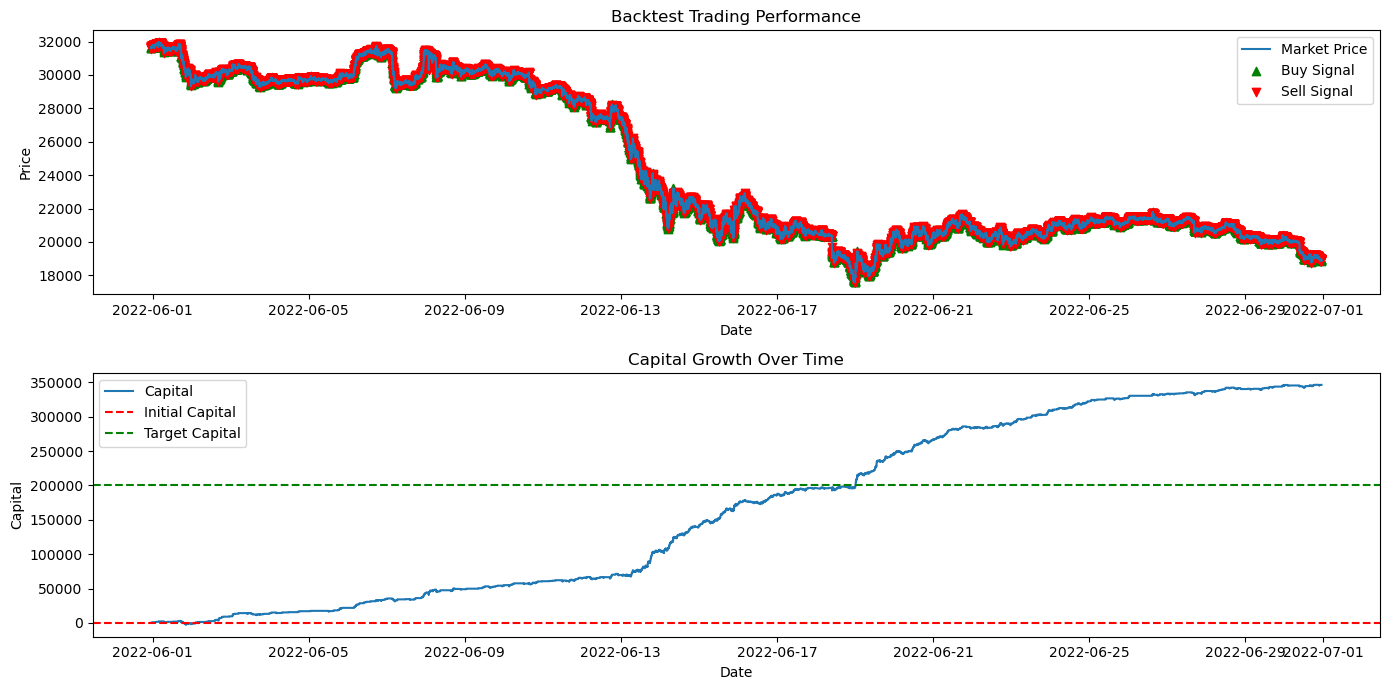

Precision: 0.4515
Recall: 1.0000
F1 Score: 0.6221
Accuracy: 0.8619


In [66]:
#Backtesting--Part 2
# Fetch historical data from MetaTrader 5
symbol = "BTCUSD"
timeframe = mt5.TIMEFRAME_M1
utc_from = datetime.datetime(2022, 6, 1)
utc_to = datetime.datetime(2022, 7, 1)
rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_to)
if rates is None:
    print("Failed to fetch rates, error code:", mt5.last_error())
else:
    print(f"Fetched {len(rates)} rates")

# Create DataFrame from the rates
rates_frame = pd.DataFrame(rates)
rates_frame['time'] = pd.to_datetime(rates_frame['time'], unit='s')
rates_frame.set_index('time', inplace=True)

# Feature engineering
rates_frame['Change_Open_Close'] = ((rates_frame['close'] - rates_frame['open']) / rates_frame['open']) * 100
rates_frame['Change_High_Low'] = ((rates_frame['high'] - rates_frame['low']) / rates_frame['high']) * 100
rates_frame['Profit_Between_Time_Series'] = rates_frame['Change_Open_Close'].diff().fillna(0)
rates_frame['Buy_Signal'] = (rates_frame['Profit_Between_Time_Series'] > 0.165).astype(int)
rates_frame['Sell_Signal'] = rates_frame['Buy_Signal'].shift(-1).fillna(0).astype(int)

# Prepare features for model prediction
features = rates_frame.drop(columns=['Buy_Signal', 'Sell_Signal']).values
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Predicting buy signals
with torch.no_grad():
    inputs = torch.tensor(scaled_features, dtype=torch.float32).to(device)
    outputs = model(inputs.unsqueeze(1))
    predicted_signals = torch.argmax(outputs, dim=1).cpu().numpy()

rates_frame['Predicted_Buy_Signal'] = predicted_signals

# Backtesting with leverage and profit cap
initial_capital = 100
risk_per_trade = 10  # Risking $10 per trade
capital = initial_capital
leverage = 100  # 1:100 leverage
capital_history = []

# Profit cap parameter
profit_cap_percentage = 0.165  # Cap the profit at this percentage

# Trade log
trade_log = []

# Initialize variables
entry_price = None
positions = 0

for i in range(len(rates_frame)):
    date_time = rates_frame.index[i]
    current_price = rates_frame['close'].iloc[i]

    if rates_frame['Predicted_Buy_Signal'].iloc[i] == 1 and positions == 0:
        # Enter position
        positions = leverage * (risk_per_trade / current_price)
        entry_price = current_price
        trade_log.append(f"Entered position at index {i}, time {date_time}, price: {entry_price}, positions: {positions}, capital: {capital}")

    if positions != 0:
        profit_percentage = (current_price - entry_price) / entry_price * 100

        if profit_percentage >= profit_cap_percentage or profit_percentage <= -1:
            # Exit position due to reaching profit cap or stop loss
            profit = positions * (current_price - entry_price) * leverage
            capital += profit

            trade_log.append(f"Exited position at index {i}, time {date_time}, price: {current_price}, profit_percentage: {profit_percentage}, profit: {profit}, capital: {capital}")

            # Compound the capital if profit was made
            if profit_percentage >= profit_cap_percentage:
                capital += profit  # Add profit directly to capital

            # Reset positions
            positions = 0
            entry_price = None

    # Update capital history
    capital_history.append(capital)

# Output trade log
for log in trade_log:
    print(log)

# Plotting the results
rates_frame['Capital'] = capital_history

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(rates_frame.index, rates_frame['close'], label='Market Price')
plt.scatter(rates_frame.index[rates_frame['Predicted_Buy_Signal'] == 1], rates_frame['close'][rates_frame['Predicted_Buy_Signal'] == 1], marker='^', color='green', alpha=1, label='Buy Signal')
plt.scatter(rates_frame.index[rates_frame['Predicted_Buy_Signal'] == 0], rates_frame['close'][rates_frame['Predicted_Buy_Signal'] == 0], marker='v', color='red', alpha=1, label='Sell Signal')
plt.title('Backtest Trading Performance')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(rates_frame.index, rates_frame['Capital'], label='Capital')
plt.axhline(y=initial_capital, color='r', linestyle='--', label='Initial Capital')
plt.axhline(y=200000, color='g', linestyle='--', label='Target Capital')
plt.title('Capital Growth Over Time')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate performance metrics
actual_signals = rates_frame['Buy_Signal'].values
precision = precision_score(actual_signals, predicted_signals)
recall = recall_score(actual_signals, predicted_signals)
f1 = f1_score(actual_signals, predicted_signals)
accuracy = accuracy_score(actual_signals, predicted_signals)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

In [67]:
#Backtesting
# Install Required Packages
!pip install MetaTrader5 pandas numpy torch matplotlib scikit-learn

# Imports and Model Definition
import MetaTrader5 as mt5
import pandas as pd
import datetime
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

# Define the RNN model with batch normalization and 15 activation layers
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fc7 = nn.Linear(hidden_size, hidden_size)
        self.fc8 = nn.Linear(hidden_size, hidden_size)
        self.fc9 = nn.Linear(hidden_size, hidden_size)
        self.fc10 = nn.Linear(hidden_size, hidden_size)
        self.fc11 = nn.Linear(hidden_size, hidden_size)
        self.fc12 = nn.Linear(hidden_size, hidden_size)
        self.fc13 = nn.Linear(hidden_size, hidden_size)
        self.fc14 = nn.Linear(hidden_size, hidden_size)
        self.fc15 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.relu(self.fc4(out))
        out = torch.relu(self.fc5(out))
        out = torch.relu(self.fc6(out))
        out = torch.relu(self.fc7(out))
        out = torch.relu(self.fc8(out))
        out = torch.relu(self.fc9(out))
        out = torch.relu(self.fc10(out))
        out = torch.relu(self.fc11(out))
        out = torch.relu(self.fc12(out))
        out = torch.relu(self.fc13(out))
        out = torch.relu(self.fc14(out))
        out = self.fc15(out)
        return out

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# Load the trained model
model_path = "C:/Users/gunne/Documents/PriceNeuralNetwork/ProfitBS0.5/005model.pth"
model = BitcoinPriceLSTM(input_size=10, hidden_size=512, num_layers=3, output_size=2, dropout=0.5).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Connect to MetaTrader 5
if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()
else:
    print("MetaTrader 5 initialized successfully")

# Login to the demo account
account = 51806647  # Ensure the account number is an integer
password = "lKDtOjEK6$rp@f"
server = "ICMarketsSC-Demo"

# Debug print for login details
print(f"Attempting to login with Account: {account}, Password: {password}, Server: {server}")

authorized = mt5.login(login=account, password=password, server=server)
if not authorized:
    print(f"Failed to connect to account #{account}, error code: {mt5.last_error()}")
else:
    print(f"Connected to account #{account}")


  Obtaining dependency information for tbb==2021.* from https://files.pythonhosted.org/packages/7b/2d/1e1c70fae8ace27e6200fb71c2372a9aeac2baba474b1609d7d466e969b4/tbb-2021.12.0-py3-none-win_amd64.whl.metadata
  Using cached tbb-2021.12.0-py3-none-win_amd64.whl.metadata (1.1 kB)
Using cached tbb-2021.12.0-py3-none-win_amd64.whl (286 kB)
  Attempting uninstall: tbb
    Found existing installation: TBB 0.2
Running on device: cuda
MetaTrader 5 initialized successfully
Attempting to login with Account: 51806647, Password: lKDtOjEK6$rp@f, Server: ICMarketsSC-Demo
Connected to account #51806647


ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [ ]:
#Now lets do this with the dummy money traded with our account, part 2:

# Trading parameters
initial_capital = 1000
capital = initial_capital
leverage = 1  # No leverage used
profit_cap_percentage = 0.05
stop_loss_percentage = 1.0  # Stop loss at 1%
positions = 0
entry_price = None

# Trade log
trade_log = []

# Create a new folder for the current test
current_test_index = 0
base_log_dir = "trading_logs"
os.makedirs(base_log_dir, exist_ok=True)

# Find the next available folder index
while os.path.exists(os.path.join(base_log_dir, f"test_{current_test_index}")):
    current_test_index += 1

current_log_dir = os.path.join(base_log_dir, f"test_{current_test_index}")
os.makedirs(current_log_dir)

log_file_path = os.path.join(current_log_dir, "trade_log.txt")
log_csv_path = os.path.join(current_log_dir, "trade_log.csv")
iteration_csv_path = os.path.join(current_log_dir, "iteration_log.csv")

# DataFrames for logs
trade_log_df = pd.DataFrame(columns=['time', 'action', 'price', 'positions', 'capital', 'profit_percentage', 'profit'])
iteration_log_df = pd.DataFrame(columns=['time', 'price', 'positions', 'capital'])

def validate_volume(raw_volume, symbol):
    # Adjust the volume to match the broker's requirements
    min_volume = mt5.symbol_info(symbol).volume_min
    max_volume = mt5.symbol_info(symbol).volume_max
    step_volume = mt5.symbol_info(symbol).volume_step

    if raw_volume < min_volume:
        return min_volume
    elif raw_volume > max_volume:
        return max_volume
    else:
        return round(raw_volume / step_volume) * step_volume

# Run the trading loop
while True:
    # Fetch live data
    rates = mt5.copy_rates_from_pos("BTCUSD", mt5.TIMEFRAME_M1, 0, 100)
    rates_frame = pd.DataFrame(rates)
    rates_frame['time'] = pd.to_datetime(rates_frame['time'], unit='s')
    rates_frame.set_index('time', inplace=True)

    # Feature engineering
    rates_frame['Change_Open_Close'] = ((rates_frame['close'] - rates_frame['open']) / rates_frame['open']) * 100
    rates_frame['Change_High_Low'] = ((rates_frame['high'] - rates_frame['low']) / rates_frame['high']) * 100
    rates_frame['Profit_Between_Time_Series'] = rates_frame['Change_Open_Close'].diff().fillna(0)
    rates_frame['Buy_Signal'] = (rates_frame['Profit_Between_Time_Series'] > 0.165).astype(int)
    rates_frame['Sell_Signal'] = rates_frame['Buy_Signal'].shift(-1).fillna(0).astype(int)

    # Prepare features for model prediction
    features = rates_frame.drop(columns=['Buy_Signal', 'Sell_Signal']).values
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Predicting buy signals
    with torch.no_grad():
        inputs = torch.tensor(scaled_features, dtype=torch.float32).to(device)
        outputs = model(inputs.unsqueeze(1))
        predicted_signals = torch.argmax(outputs, dim=1).cpu().numpy()

    rates_frame['Predicted_Buy_Signal'] = predicted_signals

    # Execute trades based on predictions
    current_price = rates_frame['close'].iloc[-1]
    date_time = datetime.datetime.now()
    risk_per_trade = capital * 0.01  # Risk 1% of current capital per trade

    if rates_frame['Predicted_Buy_Signal'].iloc[-1] == 1 and positions == 0:
        # Enter position
        raw_volume = risk_per_trade / current_price
        validated_volume = validate_volume(raw_volume, "BTCUSD")

        positions = validated_volume
        entry_price = current_price
        stop_loss_price = entry_price - (entry_price * stop_loss_percentage / 100)
        log_entry = {
            'time': date_time,
            'action': 'enter',
            'price': entry_price,
            'positions': positions,
            'capital': capital,
            'profit_percentage': None,
            'profit': None
        }
        trade_log_df = pd.concat([trade_log_df, pd.DataFrame([log_entry])], ignore_index=True)
        with open(log_file_path, "a") as log_file:
            log_file.write(f"Entered position at time {date_time}, price: {entry_price}, positions: {positions}, capital: {capital}\n")

    if positions != 0:
        profit_percentage = (current_price - entry_price) / entry_price * 100

        if profit_percentage >= profit_cap_percentage or current_price <= stop_loss_price:
            # Exit position due to reaching profit cap or stop loss
            profit = positions * (current_price - entry_price) * leverage
            capital += profit

            if current_price <= stop_loss_price:
                # Reduce capital by the risked amount
                capital -= risk_per_trade

            log_exit = {
                'time': date_time,
                'action': 'exit',
                'price': current_price,
                'positions': positions,
                'capital': capital,
                'profit_percentage': profit_percentage,
                'profit': profit
            }
            trade_log_df = pd.concat([trade_log_df, pd.DataFrame([log_exit])], ignore_index=True)
            with open(log_file_path, "a") as log_file:
                log_file.write(f"Exited position at time {date_time}, price: {current_price}, profit_percentage: {profit_percentage}, profit: {profit}, capital: {capital}\n")

            # Reset positions
            positions = 0
            entry_price = None

    # Print details of each iteration
    iteration_log = {
        'time': date_time,
        'price': current_price,
        'positions': positions,
        'capital': capital
    }
    iteration_log_df = pd.concat([iteration_log_df, pd.DataFrame([iteration_log])], ignore_index=True)
    print(f"Iteration at time {date_time}, current price: {current_price}, positions: {positions}, capital: {capital}")
    with open(log_file_path, "a") as log_file:
        log_file.write(f"Iteration at time {date_time}, current price: {current_price}, positions: {positions}, capital: {capital}\n")

    # Save logs to CSV files
    trade_log_df.to_csv(log_csv_path, index=False)
    iteration_log_df.to_csv(iteration_csv_path, index=False)

    # Wait before the next iteration (e.g., 1 minute)
    time.sleep(60)